In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import Levenshtein
import librosa
import matplotlib.pyplot as plt
import MorseCodePy as mcp
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import re

In [3]:
def encode_to_morse(text: str, remove_separator_pad=False):
    encoded = mcp.encode(text, language='russian')
    sharp_code = '--.--'    # #
    hard_code = '.--.-.'
    common_hard_code = '--.--'  # Ъ
    encoded = encoded.replace(common_hard_code, hard_code)
    encoded = encoded.replace('*', sharp_code)

    if remove_separator_pad:
        encoded = encoded.replace('/ ', '/')
        encoded = encoded.replace(' /', '/')
    return encoded

def decode_from_morse(morse: str, separator_pads_removed=False):
    sharp_code = '--.--'    # #
    hard_code = '.--.-.'
    common_hard_code = '--.--'  # Ъ
    # # -> ? -> #
    question_mark_code = '..--..'   # ?
    code = morse.replace(sharp_code, question_mark_code)
    code = code.replace(hard_code, common_hard_code)
    if separator_pads_removed:
        code = code.replace('/', ' / ').strip(' ')
    text = mcp.decode(code, language='russian')
    text = text.replace('?', '#').upper()
    return text

class Vectorizer:
    def __init__(self):
        self.text_to_nums = {
            ' ': 0,
            '.': 1,
            '-': 2,
            '/': 3,
            }
        self.nums_to_text = dict([(v, k) for k, v in self.text_to_nums.items()])
        pass

    def to_tensor(self, text: str):
        return torch.tensor([self.text_to_nums[ch] for ch in text])
    
    def from_tensor(self, tensor: torch.Tensor):
        assert tensor.ndim == 1
        return ''.join([self.nums_to_text[num.item()] for num in tensor])

In [4]:
vec_maker = Vectorizer()

def text_transform(text: str):
    encoded = encode_to_morse(text)
    return vec_maker.to_tensor(encoded) + 1 # for CTC loss


def batch_text_transform(texts: list[str], pad_value = 1):
    vecs = []
    for t in texts:
        vecs.append(text_transform(t))
    lengths = torch.tensor([len(v) for v in vecs])
    desired_length = torch.max(lengths)
    vecs = [F.pad(v, (0, desired_length - len(v)), value=pad_value) for v in vecs]
    batch = torch.stack(vecs, dim=0)
    return batch, lengths

In [5]:
def load_tensors(dir_path, filenames):
    for name in filenames:
        path = Path(dir_path, name)
        yield torch.load(path)

In [6]:
class ListDataset(torch.utils.data.Dataset):
    def __init__(self, features: list, labels: list):
        self.features = features
        self.labels = labels
        assert len(features) == len(labels)
        pass

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# time to train it

In [7]:
full_train_df = pd.read_csv('train.csv')[:6000]
test_df = pd.read_csv('test.csv')

def filenames_to_torch(filenames):
    for name in filenames:
        yield Path(name).with_suffix('.pt')

In [8]:
full_train_features = list(tqdm(load_tensors('data\entropy_nfft512_nc64', filenames_to_torch(full_train_df['id']))))
full_train_labels = list(full_train_df['message'])
len(full_train_features)

6000it [00:41, 145.56it/s]


6000

..... -.- -..- --.- . ..-.. ... --.


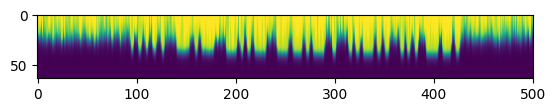

In [9]:
plt.imshow(full_train_features[653])
print(encode_to_morse(full_train_df.iloc[653]['message']))

In [10]:
from sklearn.model_selection import train_test_split

precomputed_full_train_dataset = ListDataset(full_train_features, full_train_labels)
train_index, val_index = train_test_split(np.arange(len(precomputed_full_train_dataset)), test_size=1/6, shuffle=True, 
                                           random_state=42)
print(train_index.shape, val_index.shape)
trainset = torch.utils.data.Subset(precomputed_full_train_dataset, train_index)
valset = torch.utils.data.Subset(precomputed_full_train_dataset, val_index)

(5000,) (1000,)


In [11]:
# class SimpleConvModel(nn.Module):
#     def __init__(self, input_size=64, inner_size=16, output_size=5):
#         super().__init__()
#         self.estimator = nn.Sequential(
#             nn.Conv1d(input_size, inner_size, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(inner_size),
#             nn.Conv1d(inner_size, inner_size, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(inner_size),
#             nn.MaxPool1d(2, 2),
#             nn.Conv1d(inner_size, inner_size, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(inner_size),
#             nn.Conv1d(inner_size, output_size, kernel_size=3),
#         )
#         pass

#     def forward(self, x):
#         out = self.estimator(x)
#         return out

In [24]:
class ResBlock(nn.Module):
        def __init__(self, size, p_dropout):
            super().__init__()
            self.cell = nn.Sequential(
                nn.Conv1d(size, size, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(size),
                nn.Dropout(p=p_dropout),
                nn.Conv1d(size, size, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(size),
                nn.Dropout(p=p_dropout),
            )
            self.activation = nn.ReLU()
            pass

        def forward(self, x):
            return self.activation(x + self.cell(x))
        pass


class MyResNet(nn.Module):
    def __init__(self, n_blocks: int, input_size=64, inner_size=16, output_size=5, p_dropout = 0.1):
        super().__init__()
        self.inner_size = inner_size
        self.p_dropout = p_dropout
        self.estimator = nn.Sequential(
            nn.Conv1d(input_size, inner_size, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(inner_size),
            nn.Dropout(),
            *[ResBlock(inner_size, p_dropout) for i in range(n_blocks)],
            nn.Conv1d(inner_size, output_size, kernel_size=3),
        )
        pass

    def forward(self, x):
        return self.estimator(x)

In [25]:
# class BroadSimpleConvModel(nn.Module):
#     def __init__(self, input_size=64, inner_size=16, output_size=5):
#         super().__init__()
#         self.estimator = nn.Sequential(
#             nn.Conv1d(input_size, inner_size, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(inner_size),
#             nn.Conv1d(inner_size, inner_size, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(inner_size),
#             # nn.MaxPool1d(2, 2),
#             nn.Conv1d(inner_size, inner_size, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm1d(inner_size),
#             nn.Conv1d(inner_size, output_size, kernel_size=3),
#         )
#         pass

#     def forward(self, x):
#         out = self.estimator(x)
#         return out

In [26]:
device = 0 if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [33]:
model = MyResNet(12, inner_size=32).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
ctc_loss = nn.CTCLoss()


train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

train_loss_history = []
test_loss_history = []
for epoch in range(15):
    model.train()
    train_loss_buffer = []
    for features, labels in tqdm(train_loader):
        features = features.to(device)
        targets, target_lengths = batch_text_transform(labels)
        targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
        outs = model(features).transpose(0, 2).transpose(1, 2)
        inputs = F.log_softmax(outs, dim=2)
        input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
        loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_buffer.append(loss.detach())
    scheduler.step()
    model.eval()
    test_loss_buffer = []
    with torch.no_grad():
        for features, labels in tqdm(val_loader):
            features = features.to(device)
            targets, target_lengths = batch_text_transform(labels)
            targets, target_lengths = targets.to(device), target_lengths.to(torch.int32).to(device)
            outs = model(features).transpose(0, 2).transpose(1, 2)
            inputs = F.log_softmax(outs, dim=2)
            input_lengths = torch.full(size=(inputs.shape[1],), fill_value=inputs.shape[0], dtype=torch.int32).to(device)
            loss = ctc_loss(inputs, targets, input_lengths, target_lengths)
            test_loss_buffer.append(loss.detach())
    # print(train_loss_buffer)
    train_loss_value = torch.mean(torch.stack(train_loss_buffer)).item()
    test_loss_value = torch.mean(torch.stack(test_loss_buffer)).item()
    print(f'train loss = {train_loss_value}; test loss = {test_loss_value}')
    train_loss_history.append(train_loss_value)
    test_loss_history.append(test_loss_value)

100%|██████████| 32/32 [00:02<00:00, 10.85it/s]


train loss = 0.889288067817688; test loss = 0.3063017725944519


100%|██████████| 32/32 [00:02<00:00, 11.71it/s]


train loss = 0.2981209456920624; test loss = 0.27329131960868835


100%|██████████| 32/32 [00:02<00:00, 11.51it/s]


train loss = 0.2363511621952057; test loss = 0.20224939286708832


100%|██████████| 32/32 [00:03<00:00,  9.69it/s]


train loss = 0.20396709442138672; test loss = 0.19555705785751343


100%|██████████| 32/32 [00:02<00:00, 12.88it/s]


train loss = 0.1921631395816803; test loss = 0.2041773498058319


100%|██████████| 32/32 [00:02<00:00, 12.29it/s]


train loss = 0.18934480845928192; test loss = 0.18066158890724182


100%|██████████| 32/32 [00:02<00:00, 11.46it/s]


train loss = 0.18177032470703125; test loss = 0.17288683354854584


100%|██████████| 32/32 [00:02<00:00, 11.78it/s]


train loss = 0.1774342954158783; test loss = 0.1702590137720108


100%|██████████| 32/32 [00:02<00:00, 11.28it/s]


train loss = 0.17064224183559418; test loss = 0.16571727395057678


100%|██████████| 32/32 [00:02<00:00, 12.15it/s]


train loss = 0.16118502616882324; test loss = 0.14632627367973328


100%|██████████| 32/32 [00:02<00:00, 12.33it/s]


train loss = 0.1535915732383728; test loss = 0.1476726233959198


100%|██████████| 32/32 [00:02<00:00, 11.36it/s]


train loss = 0.15016230940818787; test loss = 0.13809742033481598


100%|██████████| 32/32 [00:02<00:00, 12.53it/s]


train loss = 0.14824919402599335; test loss = 0.14589303731918335


100%|██████████| 32/32 [00:02<00:00, 12.45it/s]


train loss = 0.14556723833084106; test loss = 0.1462840437889099


100%|██████████| 32/32 [00:02<00:00, 12.03it/s]

train loss = 0.14454111456871033; test loss = 0.1424410045146942


Text(0, 0.5, 'value')

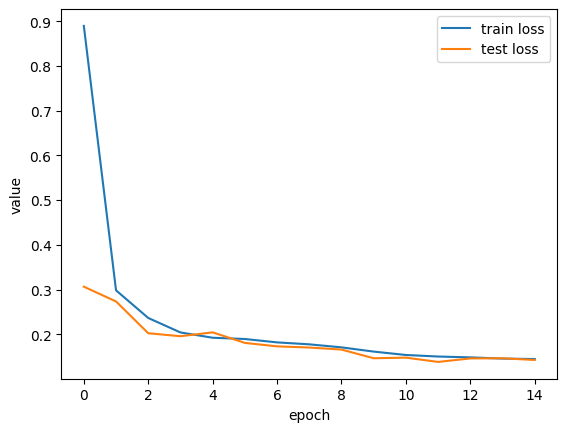

In [34]:
plt.plot(train_loss_history)
plt.plot(test_loss_history)
plt.legend(['train loss', 'test loss'])
plt.xlabel('epoch')
plt.ylabel('value')

# inference

In [16]:
def map_to_string(tensor: torch.Tensor):
    assert tensor.ndim == 1
    result = []
    the_map = ['$', ' ', '.', '-', '/']
    for i in tensor:
        result.append(the_map[i])
    return ''.join(result)


def prettify_ctc_string(ctc_string):
    text = ctc_string
    text = re.sub('-+', '-', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('/+', '/', text)
    text = re.sub('\.+', '.', text)
    text = re.sub('\$+', '', text)
    text = text.strip()
    return text

In [17]:
"""
Author: Awni Hannun
This is an example CTC decoder written in Python. The code is
intended to be a simple example and is not designed to be
especially efficient.
The algorithm is a prefix beam search for a model trained
with the CTC loss function.
For more details checkout either of these references:
  https://distill.pub/2017/ctc/#inference
  https://arxiv.org/abs/1408.2873
"""

import numpy as np
import math
import collections

NEG_INF = -float("inf")

class LongCTCSampler:
  @staticmethod
  def make_new_beam():
    fn = lambda : (NEG_INF, NEG_INF)
    return collections.defaultdict(fn)

  @staticmethod
  def logsumexp(*args):
    """
    Stable log sum exp.
    """
    if all(a == NEG_INF for a in args):
        return NEG_INF
    a_max = max(args)
    lsp = math.log(sum(math.exp(a - a_max)
                        for a in args))
    return a_max + lsp

  @staticmethod
  def decode(probs, beam_size=100, blank=0):
    """
    Performs inference for the given output probabilities.
    Arguments:
        probs: The output probabilities (e.g. post-softmax) for each
          time step. Should be an array of shape (time x output dim).
        beam_size (int): Size of the beam to use during inference.
        blank (int): Index of the CTC blank label.
    Returns the output label sequence and the corresponding negative
    log-likelihood estimated by the decoder.
    """
    T, S = probs.shape
    probs = np.log(probs)

    # Elements in the beam are (prefix, (p_blank, p_no_blank))
    # Initialize the beam with the empty sequence, a probability of
    # 1 for ending in blank and zero for ending in non-blank
    # (in log space).
    beam = [(tuple(), (0.0, NEG_INF))]

    for t in range(T): # Loop over time

      # A default dictionary to store the next step candidates.
      next_beam = LongCTCSampler.make_new_beam()

      for s in range(S): # Loop over vocab
        p = probs[t, s]

        # The variables p_b and p_nb are respectively the
        # probabilities for the prefix given that it ends in a
        # blank and does not end in a blank at this time step.
        for prefix, (p_b, p_nb) in beam: # Loop over beam

          # If we propose a blank the prefix doesn't change.
          # Only the probability of ending in blank gets updated.
          if s == blank:
            n_p_b, n_p_nb = next_beam[prefix]
            n_p_b = LongCTCSampler.logsumexp(n_p_b, p_b + p, p_nb + p)
            next_beam[prefix] = (n_p_b, n_p_nb)
            continue

          # Extend the prefix by the new character s and add it to
          # the beam. Only the probability of not ending in blank
          # gets updated.
          end_t = prefix[-1] if prefix else None
          n_prefix = prefix + (s,)
          n_p_b, n_p_nb = next_beam[n_prefix]
          if s != end_t:
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_b + p, p_nb + p)
          else:
            # We don't include the previous probability of not ending
            # in blank (p_nb) if s is repeated at the end. The CTC
            # algorithm merges characters not separated by a blank.
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_b + p)
            
          # *NB* this would be a good place to include an LM score.
          next_beam[n_prefix] = (n_p_b, n_p_nb)

          # If s is repeated at the end we also update the unchanged
          # prefix. This is the merging case.
          if s == end_t:
            n_p_b, n_p_nb = next_beam[prefix]
            n_p_nb = LongCTCSampler.logsumexp(n_p_nb, p_nb + p)
            next_beam[prefix] = (n_p_b, n_p_nb)

      # Sort and trim the beam before moving on to the
      # next time-step.
      beam = sorted(next_beam.items(),
              key=lambda x : LongCTCSampler.logsumexp(*x[1]),
              reverse=True)
      beam = beam[:beam_size]

    best = beam[0]
    return best[0], -LongCTCSampler.logsumexp(*best[1])
  
  @staticmethod
  def sample(probs: torch.Tensor, beam_size=100):
    # probs.shape = [C, T]
    sequence, likelihood = LongCTCSampler.decode(np.asarray(probs.transpose(1, 0)), beam_size=beam_size)
    return sequence, likelihood
  
  @staticmethod
  def sample_in_morse(probs: torch.Tensor, beam_size=100, return_prob=False):
    sequence, likelihood = LongCTCSampler.sample(probs, beam_size=beam_size)
    morse = map_to_string(torch.tensor(sequence))
    morse = morse.strip(' /')
    if return_prob:
      return morse, likelihood
    return morse

In [35]:
with torch.no_grad():
    distance_buffer = []
    for features, labels in tqdm(valset):
        features = features.to(device)
        outs = model(features[None]).squeeze().to('cpu')
        probs = F.softmax(outs, dim=0)
        morse = LongCTCSampler.sample_in_morse(probs, beam_size=10)
        decoded_message = decode_from_morse(morse)
        dist = Levenshtein.distance(decoded_message, labels)
        distance_buffer.append(dist)
    mean_dist = np.mean(distance_buffer)
mean_dist

  0%|          | 2/1000 [00:00<02:58,  5.60it/s]C:\Users\Alex\AppData\Local\Temp\ipykernel_16468\4165096537.py:50: RuntimeWarning: divide by zero encountered in log
  probs = np.log(probs)
100%|██████████| 1000/1000 [02:19<00:00,  7.15it/s]


np.float64(1.408)

# submission

0it [00:00, ?it/s]

5000it [00:06, 787.22it/s]


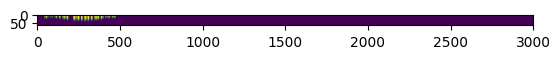

In [36]:
test_features = list(tqdm(load_tensors('data\entropy_nfft512_nc64', filenames_to_torch(test_df['id']))))
plt.imshow(test_features[-1])

In [37]:
decoded_list = []
model.eval()
for features in tqdm(test_features):
    with torch.no_grad():
        outs = model(features[None].to(device))
        probs = F.softmax(outs.squeeze(), dim=0)
    long_alg_string = LongCTCSampler.sample_in_morse(probs, beam_size=10)
    decoded = decode_from_morse(long_alg_string)
    decoded_list.append(decoded)

  0%|          | 1/5000 [00:00<12:21,  6.74it/s]C:\Users\Alex\AppData\Local\Temp\ipykernel_16468\4165096537.py:50: RuntimeWarning: divide by zero encountered in log
  probs = np.log(probs)
100%|██████████| 5000/5000 [19:21<00:00,  4.30it/s]


In [43]:
submission_df = pd.DataFrame({'id': test_df['id'], 'message': decoded_list})
submission_df.head()

,id,message
0,30001.opus,ЯЮ6ЛИТЖБШ
1,30002.opus,КЩВ9Ю9
2,30003.opus,Ы65Ф61Я
3,30004.opus,ЖЖНЖ9РЫНЦ3
4,30005.opus,ЕЯФ4ЮЧЬ


In [44]:
submission_df.to_csv('ctc_resnet_baseline.csv', index=False)

In [45]:
submission_df.tail(20)

,id,message
4980,34981.opus,ЛМ*Е*ПИ
4981,34982.opus,ЦОББСГМ8
4982,34983.opus,"5УМ0АО,"
4983,34984.opus,ИАОМШБЫМН
4984,34985.opus,**М
4985,34986.opus,4*АЩ9ФЖ
4986,34987.opus,
4987,34988.opus,ТК*НКО*
4988,34989.opus,ТКМОПО
4989,34990.opus,
